Below is the pytorch implementation of the notebook from https://pantelis.github.io/aiml-common/lectures/cnn/cnn-example-architectures/using_convnets_with_small_datasets.html . roughly the same
<br/>


In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define directories
base_dir = 'subset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


Using device: cpu


In [16]:
#augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(validation_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# making our model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model = model.to(device)

# our loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=30):
    model.train()
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        total_train_loss, total_val_loss = 0, 0
        correct_train, correct_val = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            correct_train += (outputs.round() == labels).sum().item()

        with torch.no_grad():
            model.eval()
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct_val += (outputs.round() == labels).sum().item()

        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))
        train_acc.append(correct_train / len(train_loader.dataset))
        val_acc.append(correct_val / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Train Acc: {train_acc[-1]:.4f} - Val Acc: {val_acc[-1]:.4f}')
    
    return train_losses, val_losses, train_acc, val_acc

train_losses, val_losses, train_acc, val_acc = train(model, criterion, optimizer, train_loader, val_loader, epochs=30)

Epoch 1/30 - Train Loss: 0.3681 - Val Loss: 0.1085 - Train Acc: 0.8215 - Val Acc: 0.9550
Epoch 2/30 - Train Loss: 0.7295 - Val Loss: 0.6892 - Train Acc: 0.5245 - Val Acc: 0.5000
Epoch 3/30 - Train Loss: 0.6897 - Val Loss: 0.6934 - Train Acc: 0.5370 - Val Acc: 0.5000
Epoch 4/30 - Train Loss: 0.6798 - Val Loss: 0.6538 - Train Acc: 0.5635 - Val Acc: 0.6720
Epoch 5/30 - Train Loss: 0.6789 - Val Loss: 0.6220 - Train Acc: 0.5815 - Val Acc: 0.7190
Epoch 6/30 - Train Loss: 0.7437 - Val Loss: 0.6245 - Train Acc: 0.5750 - Val Acc: 0.7050
Epoch 7/30 - Train Loss: 0.6578 - Val Loss: 0.5931 - Train Acc: 0.6200 - Val Acc: 0.7780
Epoch 8/30 - Train Loss: 0.6758 - Val Loss: 0.7092 - Train Acc: 0.5895 - Val Acc: 0.5240
Epoch 9/30 - Train Loss: 0.6674 - Val Loss: 0.5442 - Train Acc: 0.6085 - Val Acc: 0.7400
Epoch 10/30 - Train Loss: 0.6396 - Val Loss: 0.6955 - Train Acc: 0.6555 - Val Acc: 0.4580
Epoch 11/30 - Train Loss: 0.7397 - Val Loss: 0.6918 - Train Acc: 0.5405 - Val Acc: 0.5080
Epoch 12/30 - Train

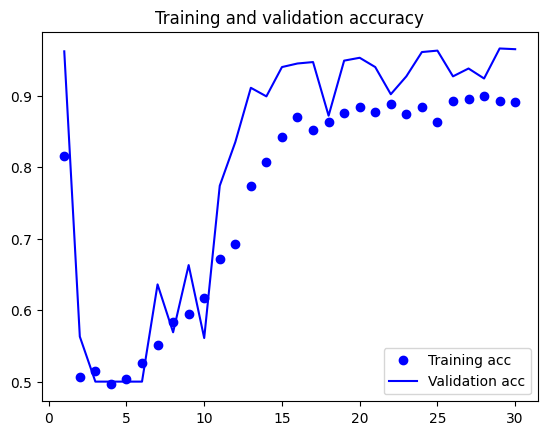

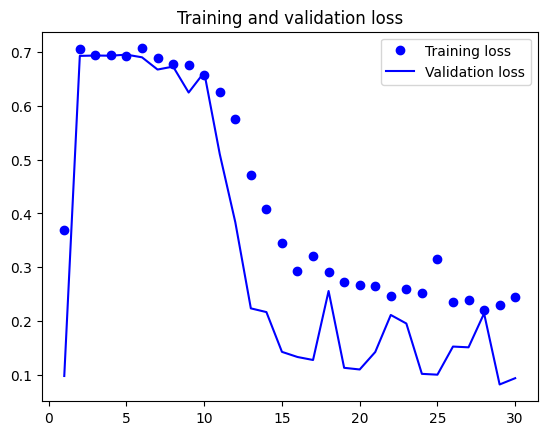

In [18]:
#Plot training and validation
epochs = range(1, 31)
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

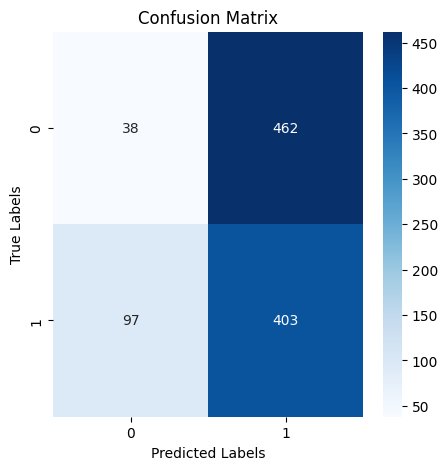

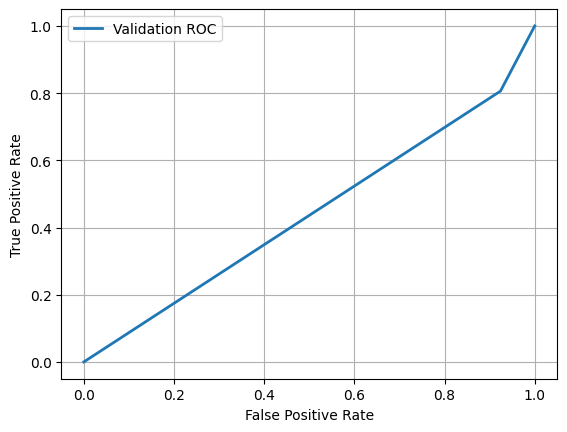

In [17]:
#confusion matrix for our eval
def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.round().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds)

val_labels, val_preds = evaluate(model, val_loader)
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

fpr, tpr, _ = roc_curve(val_labels, val_preds)
plt.plot(fpr, tpr, linewidth=2, label="Validation ROC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

Integrated Gradients allows us to compute attributions pixel level and their importance to how each part of the image contributes to the model's prediction. we first create a baseline image usually making it all black. Then we interpolate the basline image to the original image. next we calculate the gradient of the prediction out for each step. At the end we combine all the gradients from each step to compute the final calculations.

In the example below we first resize our image using pyvision and convert to a tensor. then we do the steps above, starting with a baseline image(in this case all black image) and interpolate to the original image, collect each gradient and aggregate them all at the very end. In our visualize function, we use a attribution map to to see what parts of the image contributed most to the prediction of the model.

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img).unsqueeze(0)
    return img.to(device)

def compute_integrated_gradients(model, input_image, baseline=None, steps=50):
    ig = IntegratedGradients(model)

    if baseline is None:
        baseline = torch.zeros_like(input_image).to(device)
    
    attributions = ig.attribute(input_image, baselines=baseline, n_steps=steps)
    return attributions

# visualization
def visualize_integrated_gradients(attributions, original_image):
    attributions = attributions.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    attributions = np.mean(attributions, axis=2)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")
    
    ax[1].imshow(attributions, cmap='hot')
    ax[1].axis('off')
    ax[1].set_title("Integrated Gradients")
    plt.show()

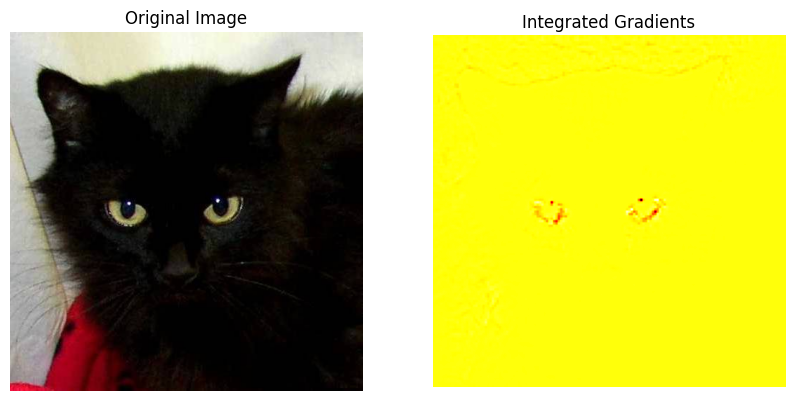

In [25]:
img_path = 'subset/test/cats/cat.1500.jpg'
input_image = load_image(img_path)
original_image = Image.open(img_path)

attributions = compute_integrated_gradients(model, input_image)
visualize_integrated_gradients(attributions, original_image)

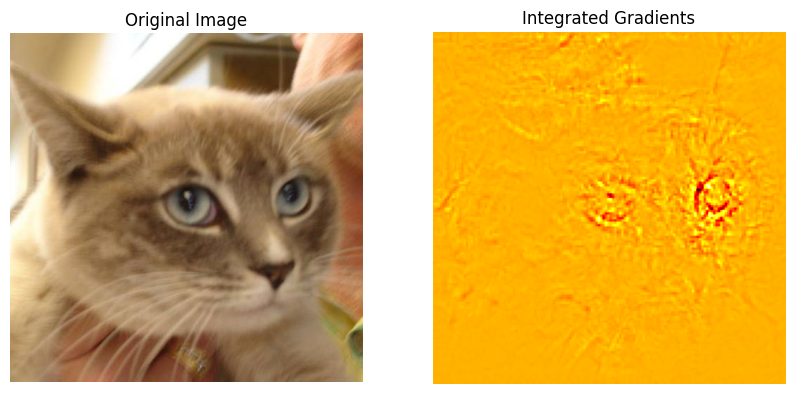

In [26]:
img_path = 'subset/test/cats/cat.1512.jpg' 
input_image = load_image(img_path)
original_image = Image.open(img_path)

attributions = compute_integrated_gradients(model, input_image)
visualize_integrated_gradients(attributions, original_image)

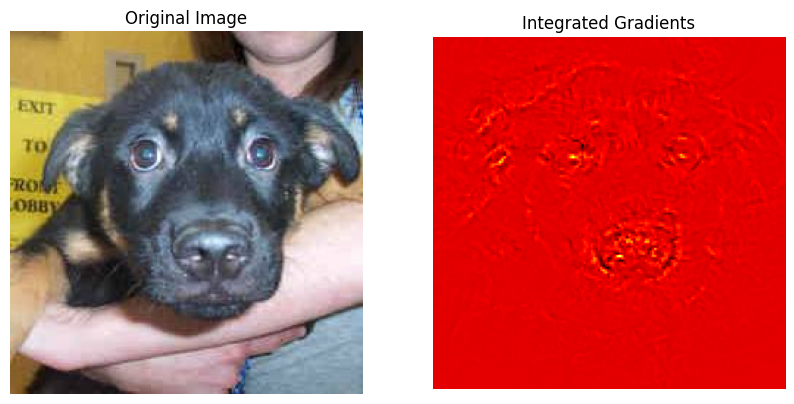

In [30]:
img_path = 'subset/test/dogs/dog.1577.jpg'  
input_image = load_image(img_path)
original_image = Image.open(img_path)

attributions = compute_integrated_gradients(model, input_image)
visualize_integrated_gradients(attributions, original_image)

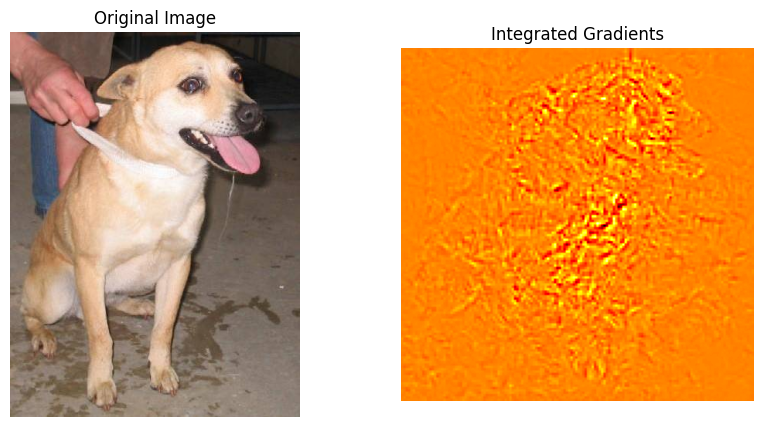

In [71]:
img_path = 'subset/test/dogs/dog.1673.jpg'  
input_image = load_image(img_path)
original_image = Image.open(img_path)

attributions = compute_integrated_gradients(model, input_image)
visualize_integrated_gradients(attributions, original_image)

The attribution heatmap shows regions in the image that contributed most strongly to the model’s prediction. Importance regions are colored in warmer tones, indicating areas that had a significant positive impact on the model’s decision for the selected class.